In [8]:
import scipy.io as sio
import numpy as np
from copy import deepcopy
from scipy.optimize import minimize
from scipy.linalg import expm
from matplotlib import pyplot as plt
from scipy.special import erf
from mpl_toolkits.mplot3d import Axes3D
import cmath
import matplotlib
import hubbard_1d
import quspin
import fejer_kernel
import fourier_filter
import generate_cdf
from qcels import *
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['lines.markersize'] = 10
np.set_printoptions(threshold=np.inf)

In [ ]:
import numpy as np
from scipy.linalg import eigh

def create_hubbard_hamiltonian_2d(nx, ny, t, U):
    """
    Creates the Hamiltonian matrix for the 2D Hubbard model.

    Parameters:
    nx, ny (int): Number of lattice sites in x and y directions.
    t (float): Hopping parameter.
    U (float): On-site interaction parameter.

    Returns:
    numpy.ndarray: Hamiltonian matrix.
    """
    n_sites = nx * ny
    dim = 4**n_sites  # Dimension of the Hilbert space

    hamiltonian = np.zeros((dim, dim), dtype=complex)

    for i in range(dim):
        binary_i = bin(i)[2:].zfill(2 * n_sites)
        state_i = [int(binary_i[j:j+2], 2) for j in range(0, 2 * n_sites, 2)]

        for j in range(dim):
            binary_j = bin(j)[2:].zfill(2 * n_sites)
            state_j = [int(binary_j[k:k+2], 2) for k in range(0, 2 * n_sites, 2)]

            # Hopping term
            for site in range(n_sites):
                x, y = site % nx, site // nx
                neighbors = []
                if x > 0: neighbors.append(site - 1)
                if x < nx - 1: neighbors.append(site + 1)
                if y > 0: neighbors.append(site - nx)
                if y < ny - 1: neighbors.append(site + nx)

                for neighbor in neighbors:
                    for spin in range(2):
                        if (state_i[site] == spin + 1 and state_j[neighbor] == spin and
                            state_i[neighbor] == 0 and state_j[site] == spin + 1):
                            
                            sign = 1  # No need for Jordan-Wigner string in 2D for this simple case
                            hamiltonian[i, j] += -t * sign
                        
                        if (state_j[site] == spin + 1 and state_i[neighbor] == spin and
                            state_j[neighbor] == 0 and state_i[site] == spin + 1):
                            
                            sign = 1  # No need for Jordan-Wigner string in 2D for this simple case
                            hamiltonian[i, j] += -t * sign

            # On-site interaction term
            for site in range(n_sites):
                if state_i[site] == 3 and i == j:  # Double occupancy
                    hamiltonian[i, j] += U

    return hamiltonian

# Example usage:
nx, ny = 2, 2  # 2x2 lattice
t = 1.0  # Hopping parameter
U = 0  # On-site interaction
hamiltonian = create_hubbard_hamiltonian_2d(nx, ny, t, U)
eigenvalues, eigenvectors = eigh(hamiltonian)

#print("Eigenvalues (Energy levels):\n", eigenvalues)
print(hamiltonian)
# print("\nEigenvectors:\n", eigenvectors) # Avoid printing large eigenvector matrices

[[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -2.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]


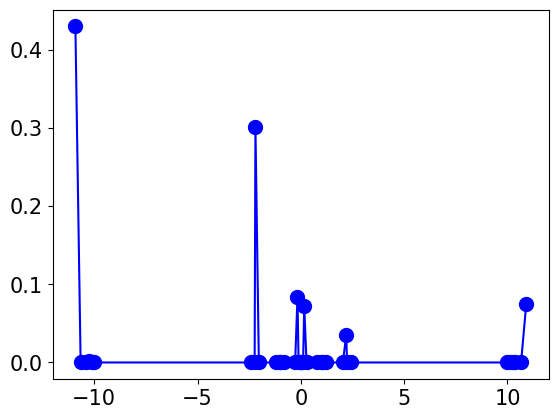

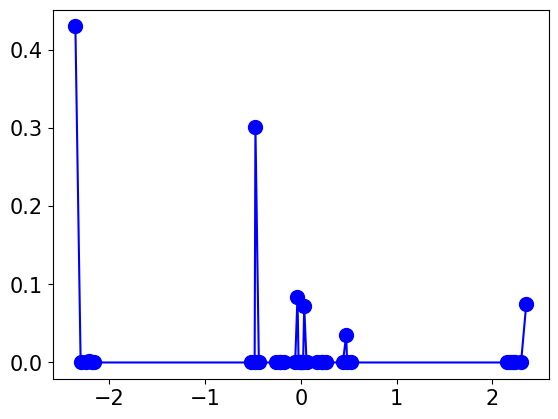

0.0547634027785322


In [15]:
###-------spectrum of Hubbard model with 4 sites---------------
num_sites = 4
J = 1.0
U = 10.0
U0 = 0.0
mu = 0.0
N_up = num_sites // 2
N_down = num_sites - N_up

num_eigenstates_max = 100

ham0 = hubbard_1d.generate_ham(num_sites, J, U0, mu, N_up, N_down)
ground_state_0 = ham0.eigsh(k=1,which="SA")[1][:,0]

ham = hubbard_1d.generate_ham(num_sites, J, U, mu, N_up, N_down)
if( num_eigenstates_max > ham.shape[0] // 2):
    eigenenergies, eigenstates = ham.eigh()
else:
    eigenenergies, eigenstates = ham.eigsh(k=num_eigenstates_max,which="SA")
ground_state = eigenstates[:,0]

population_raw = np.abs(np.dot(eigenstates.conj().T, ground_state_0))**2

plt.plot(eigenenergies,population_raw,'b-o');plt.show()

spectrum, population = generate_spectrum_population(eigenenergies, population_raw, 
                                                    [population_raw[0],population_raw[1]])

plt.plot(spectrum, population,'b-o');plt.show()

print(spectrum[1]-spectrum[0])

In [9]:
import numpy as np
from numpy.linalg import eigh
from scipy.sparse import lil_matrix, csr_matrix

def hubbard_hamiltonian_obc(n_sites, t, U):
    """
    Constructs the Hubbard model Hamiltonian with open boundary conditions.

    Args:
        n_sites (int): Number of lattice sites.
        t (float): Hopping parameter.
        U (float): On-site interaction strength.

    Returns:
        csr_matrix: Sparse matrix representation of the Hamiltonian.
    """
    dim = 2**n_sites  # Dimension of the Hilbert space
    hamiltonian = lil_matrix((dim, dim), dtype=float)

    for i in range(dim):
        binary_i = bin(i)[2:].zfill(n_sites)  # Binary representation of state i

        # Hopping term
        for j in range(n_sites - 1):
            # Check for a particle at site j and no particle at site j+1
            if binary_i[j] == '1' and binary_i[j+1] == '0':
                # Create state with particle moved to the right
                temp_list = list(binary_i)
                temp_list[j], temp_list[j+1] = temp_list[j+1], temp_list[j]
                new_binary = "".join(temp_list)
                new_state = int(new_binary, 2)
                hamiltonian[i, new_state] -= t

            # Check for a particle at site j+1 and no particle at site j
            if binary_i[j] == '0' and binary_i[j+1] == '1':
                # Create state with particle moved to the left
                temp_list = list(binary_i)
                temp_list[j], temp_list[j+1] = temp_list[j+1], temp_list[j]
                new_binary = "".join(temp_list)
                new_state = int(new_binary, 2)
                hamiltonian[i, new_state] -= t

        # On-site interaction term
        for j in range(n_sites - 1):
            if binary_i[j] == '1' and binary_i[j+1] == '1':
              hamiltonian[i,i] += U

    return csr_matrix(hamiltonian)

if __name__ == '__main__':
    n_sites = 4  # Example: 4 lattice sites
    t = 1      # Example: Hopping parameter
    U = 10       # Example: On-site interaction strength    

    hamiltonian = hubbard_hamiltonian_obc(n_sites, t, U)

    print("Hubbard Hamiltonian (sparse matrix):")
    ham = hamiltonian.toarray()/np.linalg.norm(hamiltonian.toarray(), ord=2)
    #print(ham)
    # for i in ham:
    #     for j in i:
    #         print(j, end = ' ')
    #     print()

Hubbard Hamiltonian (sparse matrix):


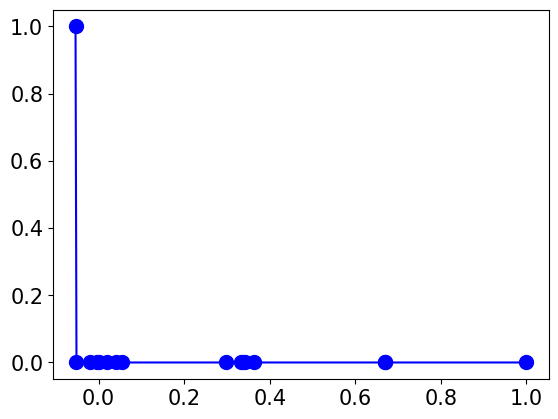

In [10]:
eigenenergies, eigenstates = eigh(ham)
#ham = ham/np.max(np.abs(eigenenergies))
#eigenenergies, eigenstates = eigh(ham)
ground_state = eigenstates[:,0]

pop = np.abs(np.dot(eigenstates.conj().T, ground_state))**2

plt.plot(eigenenergies, pop, 'b-o')
plt.show()

In [15]:
p0_array=np.array([0.4,0.1]) #initial overlap with the first eigenvector
p1_array=np.array([0.1,0.025]) #initial overlap with the second eigenvector
#relative population=0.8

T0 = 8000
N_test_QCELS = 10  #number of different circuit depths for QCELS test
N_QPE = 10  #number of different circuit depths for QCELS QPE test

small_T_list_QCELS=[25,50,100,200,600,800]
T_list_QCELS = 1150+T0/4*(np.arange(N_test_QCELS)) #circuit depth for QCELS
T_list_QCELS = np.hstack((small_T_list_QCELS,T_list_QCELS))
T_list_QPE = 1150+T0*7.5*(np.arange(N_QPE)) #circuit depth for QPE

err_QCELS=np.zeros((len(p0_array),len(T_list_QCELS)))
err_QPE=np.zeros((len(p0_array),len(T_list_QPE)))
cost_list_avg_QCELS = np.zeros((len(p0_array),len(T_list_QCELS)))
cost_list_avg_QPE = np.zeros((len(p0_array),len(T_list_QPE)))
rate_success_QCELS=np.zeros((len(p0_array),len(T_list_QCELS)))
rate_success_QPE=np.zeros((len(p0_array),len(T_list_QPE)))
max_T_QCELS=np.zeros((len(p0_array),len(T_list_QCELS)))
rel_overlap=np.zeros(len(p0_array))
Navg = 5 #number of trying
err_thres_hold=0.01
err_thres_hold_QPE=0.01


In [16]:

#-----------------------------    
for a1 in range(len(p0_array)):
    p0=p0_array[a1]
    p1=p1_array[a1]
    n_success_QCELS= np.zeros((2,len(T_list_QCELS)))
    n_success_QPE= np.zeros(len(T_list_QPE))
    for n_test in range(Navg):
        print("For p0=",p0,"For N_test=",n_test+1)
        spectrum, population = generate_spectrum_population(eigenenergies, population_raw, [p0,p1])
        #------------------QCELS(relative gap)-----------------
        # heuristic estimate of relative gap
        rel_gap_idx=0
        while sum(population[0:rel_gap_idx+1])<4*p0/3:
              rel_gap_idx+=1
        rel_gap = spectrum[rel_gap_idx]-spectrum[0]
        rel_overlap[a1]=int(p0/sum(population[0:(rel_gap_idx)])*100)/100
        d=int(15/rel_gap) #depth for eigenvalue filtering
        print("d=", d, "rel_gap = ", rel_gap, "rel_overlap", p0/sum(population[0:(rel_gap_idx)]))
        Nsample_rough=int(200/p0**2*np.log(d))#number of samples for rough estimation
        Nsample=int(15/p0**2*np.log(d))#number of samples for constructing the loss function
        for ix in range(len(T_list_QCELS)):
            T = T_list_QCELS[ix]
            NT = 5
            err_tol_rough=rel_gap/4
            ground_energy_estimate_QCELS, cost_list_QCELS_this, max_T_QCELS_this = \
                    qcels_smalloverlap(spectrum, population, T, NT, d, rel_gap, \
                                    err_tol_rough, Nsample_rough, Nsample)#QCELS with time T
            err_this_run_QCELS = np.abs(ground_energy_estimate_QCELS - spectrum[0])
            err_QCELS[a1,ix] = err_QCELS[a1,ix]+err_this_run_QCELS
            cost_list_avg_QCELS[a1,ix]=cost_list_avg_QCELS[a1,ix]+cost_list_QCELS_this
            max_T_QCELS[a1,ix]=max(max_T_QCELS[a1,ix],max_T_QCELS_this)
            if err_this_run_QCELS<err_thres_hold:
                n_success_QCELS[0,ix]+=1
       # ----------------- QPE -----------------------
        N_try_QPE=int(15*np.ceil(1.0/p0)) #number of QPE samples each time
        for ix in range(len(T_list_QPE)):
            T = int(T_list_QPE[ix])
            discrete_energies = 2*np.pi*np.arange(2*T)/(2*T) - np.pi
            dist = generate_QPE_distribution(spectrum,population,2*T) #Generate QPE samples
            samp = generate_cdf.draw_with_prob(dist,N_try_QPE)
            j_min = samp.min()
            ground_energy_estimate_QPE = discrete_energies[j_min]
            err_this_run_QPE = np.abs(ground_energy_estimate_QPE-spectrum[0])
            err_QPE[a1,ix] = err_QPE[a1,ix]+np.abs(err_this_run_QPE)
            if np.abs(err_this_run_QPE)<err_thres_hold_QPE:
                n_success_QPE[ix]+=1
            cost_list_avg_QPE[a1,ix] = T*N_try_QPE
    rate_success_QCELS[a1,:] = n_success_QCELS[0,:]/Navg
    rate_success_QPE[a1,:] = n_success_QPE[:]/Navg
    err_QCELS[a1,:] = err_QCELS[a1,:]/Navg
    err_QPE[a1,:] = err_QPE[a1,:]/Navg
    cost_list_avg_QCELS[a1,:]=cost_list_avg_QCELS[a1,:]/Navg


For p0= 0.4 For N_test= 1
d= 7 rel_gap =  1.8815796620408844 rel_overlap 0.7970177089522112
T_list [ 0.  1.  2.  3.  4.  5.  6.  7. -7. -6. -5. -4. -3. -2. -1.]
T_list [ 0.  1.  2.  3.  4.  5.  6.  7. -7. -6. -5. -4. -3. -2. -1.]
T_list [ 0.  1.  2.  3.  4.  5.  6.  7. -7. -6. -5. -4. -3. -2. -1.]
T_list [ 0.  1.  2.  3.  4.  5.  6.  7. -7. -6. -5. -4. -3. -2. -1.]
T_list [ 0.  1.  2.  3.  4.  5.  6.  7. -7. -6. -5. -4. -3. -2. -1.]
T_list [ 0.  1.  2.  3.  4.  5.  6.  7. -7. -6. -5. -4. -3. -2. -1.]
T_list [ 0.  1.  2.  3.  4.  5.  6.  7. -7. -6. -5. -4. -3. -2. -1.]
T_list [ 0.  1.  2.  3.  4.  5.  6.  7. -7. -6. -5. -4. -3. -2. -1.]
T_list [ 0.  1.  2.  3.  4.  5.  6.  7. -7. -6. -5. -4. -3. -2. -1.]
T_list [ 0.  1.  2.  3.  4.  5.  6.  7. -7. -6. -5. -4. -3. -2. -1.]
T_list [ 0.  1.  2.  3.  4.  5.  6.  7. -7. -6. -5. -4. -3. -2. -1.]
T_list [ 0.  1.  2.  3.  4.  5.  6.  7. -7. -6. -5. -4. -3. -2. -1.]
T_list [ 0.  1.  2.  3.  4.  5.  6.  7. -7. -6. -5. -4. -3. -2. -1.]
T_list [ 0.

KeyboardInterrupt: 

In [ ]:
np.savez('result_hubbard_4sites_QPE',name1=rate_success_QPE,name2=T_list_QPE,name3=cost_list_avg_QPE,name4=err_QPE)
np.savez('result_hubbard_4sites_QCELS',name1=rate_success_QCELS,name2=max_T_QCELS,name3=cost_list_avg_QCELS,name4=err_QCELS,name5=rel_overlap)